In [1]:
import numpy as np
import pylab as pl
import copy as copy

In [5]:
#Properties of a person; the population is an array of persons
person = {'infected':False, #if they're infected
          'recovered':False, #if they're recovered (can't be infected)
          'infected_day':0, #day of infection
          'recovered_day':-1, #day of recovery (should be redundant)
          'others_infected':[], #array of ids of other persons this one infected
          'cure_days':0 #how long it will take this person to be cured (how long they can infect others)
         }
    

In [21]:
#Functions to infect/cure a patient:

#Infect a person on a particular day
def infect_person(person,day):
    #Infect only if not already infected or recovered
    if not person['recovered'] and not person['infected']:
        person['infected'] = True
        person['infected_day'] = day
        #Currently, person will be ill for [a random number between 10 and 20] days
        person['cure_days']=np.random.randint(10,20)
        return True
    return False

#Cure a person on a particular day
def cure_person(person,day):
    #Cure person if enough time has passed, and they are not already recovered
    if not person['recovered'] and person['infected']:
        person['infected'] = False
        person['recovered'] = True
        person['recovered_day'] = day
        return True
    return False

#This function runs 1 epidemic using the given parameters:
#nPop - the size of the population
#n0 - the number of initial patients
#nDays - how many days to simulate
#contacts_mean and contacts_std - mean and std of the number of contacts for each person (gaussian)
#prob_infection - probabibility of infecting someone if in contact

def RunEpidemic(nPop, n0, nDays, contacts_mean, contacts_std, prob_infection):
    #Initialize the population
    Population = [] #will be an array of persons
    InfectedIndices = [] #indices of those in Population that are infected

    #Add a bunch of persons to Population:
    for i in range(nPop):
        newperson = copy.deepcopy(person)#need a deep copy because python
        Population.append(newperson)
            
        
    #Infect the first n0 patients:      
    for i in range(n0):
        infect_person(Population[i],0)
        InfectedIndices.append(i)
            
    #Arrays to store the values during the simulation                   
    new_infected = np.zeros(nDays, dtype=int) #new infections that day
    infected = np.zeros(nDays, dtype=int) #currently infected that day
    susceptible = np.zeros(nDays, dtype=int) #never been exposed that day
    recovered = np.zeros(nDays, dtype=int) #total recovered (immune) that day
    contagionRate = np.zeros(nDays, dtype=float)#the average number of people that one person has infected 
    
    #initially, nobody has recovered or infected anyone (just to initialize the arrays for day 0)
    nRecovered = 0
    nInfected_new = 0
    nRecovered_new = 0
    
    #Loop over the number of days
    for day in range(nDays):

        #Tally the counts from the previous day (so all these values are at the beginning of the day)
        nInfected = len(InfectedIndices)#number of infected people (end of yesterday or patients zero).
        infected[day] = nInfected
        
        new_infected[day] = nInfected_new#number of new infections (end of yesterday)
        
        if day >= 1: #nobody has recovered on day 0, otherwise, add those that recovered yesterday to the total
            nRecovered = recovered[day-1] + nRecovered_new
        recovered[day] = nRecovered
        nSusceptible = nPop - nInfected - nRecovered # already was healthy at the beginning of the day
        susceptible[day] = nSusceptible
        
        #Reset tallies for today:
        nRecovered_new = 0 #newly recovered today
        nInfected_new = 0 #newly infected today
        
        #Keep track of the number of people that each infected person infects (total, not just today). The average of those 
        #is then the current average number of people infected by infected people at that time (not quite R_0).
        nOthers_infected = np.zeros(nInfected,dtype=int)
        
        #Loop over the infected people:
        iinf = 0 #index to count over infected people
        #Need to sample over a copy of the indices, since Infected indices will change during the loop
        last_InfectedIndices = copy.deepcopy(InfectedIndices)
        for iper in last_InfectedIndices:           
            per = Population[iper] #This is of type person, as defined above
            
            #This person has, so far, infected this many people:
            nOthers_infected[iinf] = len(per['others_infected'])
            iinf += 1
            
            #Randomly dray a number of contacts that this person will have
            ncontacts = abs(int(np.random.normal(contacts_mean,contacts_std)))
            #Factor in the probability that they will infect those contacts:
            ncontacts = int(ncontacts*prob_infection)
            #Choose that many uniqe indices out of the population (note, this should check only for the suscpetible people**)
            infected_contacts = np.unique(np.random.randint(0,nPop,ncontacts))
            
            #Infect those people (if they're not already infected/recovered). Better would be to choose indices only
            #from the suscpetible population
            for icon in infected_contacts:
                if infect_person(Population[icon],day): #won't infect if already infected/recovered - **this is inefficient
                    per['others_infected'].append(icon)
                    InfectedIndices.append(icon)
                    nInfected_new += 1
                    
            #Check if this person has been sick for long enough to be cured (if yes, cure them!)
            if day - per['infected_day'] >= per['cure_days']:
                if cure_person(per,day):
                    InfectedIndices.remove(iper)
                    nRecovered_new +=1

        
        meanContagions = nOthers_infected.mean()
        if len(nOthers_infected) < 1:
            meanContagions = 0        
        contagionRate[day] = meanContagions
        
        print("Day:",day,"infected:",nInfected,"recovered:",nRecovered,"mean contagions per infected person:",meanContagions)
    
    print("At the end, ",susceptible[-1],"never got it")
    print(np.max(infected),"had it at the peak")
    
    contagions = []
    for per in Population:
        contagions.append(len(per['others_infected']))
    print("The mean contagion rate is:",np.mean(contagions))
    
    return infected, new_infected, recovered, susceptible, Population
    #print(Population[0])


In [22]:
##Run a simulation
nDays = 90 #simulation length
nPop = int(1e5) #the population
n0 = 35 # number infected on day 0

#Transmissibility 
contacts_mean = 1 # mean number of people in contact per day
contacts_std = 1 #std number of contacts
prob_infection = 0.5 #probability of infecting a contact

infected, new_infected, recovered, susceptible, Population = RunEpidemic(nPop,n0, nDays,contacts_mean, contacts_std,
                                                                         prob_infection)


Day: 0 infected: 35 recovered: 0 mean contagions per infected person: 0.0
Day: 1 infected: 42 recovered: 0 mean contagions per infected person: 0.16666666666666666
Day: 2 infected: 48 recovered: 0 mean contagions per infected person: 0.2708333333333333
Day: 3 infected: 57 recovered: 0 mean contagions per infected person: 0.38596491228070173
Day: 4 infected: 68 recovered: 0 mean contagions per infected person: 0.4852941176470588
Day: 5 infected: 80 recovered: 0 mean contagions per infected person: 0.5625
Day: 6 infected: 89 recovered: 0 mean contagions per infected person: 0.6067415730337079
Day: 7 infected: 102 recovered: 0 mean contagions per infected person: 0.6568627450980392
Day: 8 infected: 120 recovered: 0 mean contagions per infected person: 0.7083333333333334
Day: 9 infected: 140 recovered: 0 mean contagions per infected person: 0.75
Day: 10 infected: 163 recovered: 0 mean contagions per infected person: 0.7852760736196319
Day: 11 infected: 183 recovered: 5 mean contagions per 

Day: 88 infected: 9534 recovered: 75623 mean contagions per infected person: 0.2604363331235578
Day: 89 infected: 8543 recovered: 76824 mean contagions per infected person: 0.25354091068711226
At the end,  14633 never got it
37032 had it at the peak
The mean contagion rate is: 0.85545


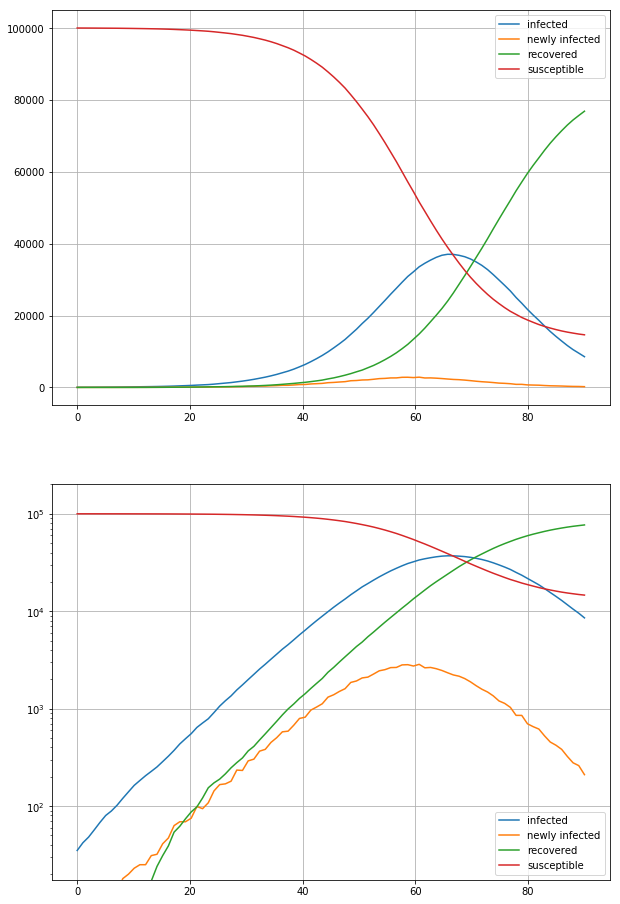

In [23]:
days = np.linspace(0,len(infected),len(infected))
fig = pl.figure(figsize=(10,16))
pl.subplot(2,1,1)
pl.grid()
pl.plot(days,infected,label="infected")
pl.plot(days,new_infected,label="newly infected")
pl.plot(days,recovered,label="recovered")
pl.plot(days,susceptible,label="susceptible")
pl.legend()
pl.subplot(2,1,2)
pl.grid()
pl.ylim(0.5*n0,2*nPop)
pl.yscale("log")
pl.plot(days,infected,label="infected")
pl.plot(days,new_infected,label="newly infected")
pl.plot(days,recovered,label="recovered")
pl.plot(days,susceptible,label="susceptible")
pl.legend()
pl.show()

#fig = pl.figure(figsize=(10,8))
#pl.hist(contagions,bins=np.linspace(0,15,16),edgecolor='black')
#pl.grid()
#pl.title("Mean contagions "+str(np.mean(contagions)))
#pl.show()
